Φόρτωση Βιβλιοθηκών

In [55]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.callbacks import EarlyStopping

Φόρτωση δεδομένων

In [21]:
try:
    train_features = pd.read_csv('train_hh_features.csv')
    train_labels   = pd.read_csv('train_hh_gt.csv')
    test_features  = pd.read_csv('test_hh_features.csv')

    print("Data loaded successfully!")
    print(f"Train features shape: {train_features.shape}")
    print(f"Train labels shape: {train_labels.shape}")
    print(f"Test features shape: {test_features.shape}")
except FileNotFoundError:
    raise FileNotFoundError("The files were not found.")

Data loaded successfully!
Train features shape: (104234, 88)
Train labels shape: (104234, 3)
Test features shape: (103023, 88)


Ένωση features με labels

In [22]:
train_df = train_features.merge(train_labels, on=['survey_id', 'hhid'], how='inner')

Έλεγχος ποιότητας δεδομένων (missing values)

In [23]:
missing_counts = train_df.isnull().sum()
missing_percent = (missing_counts / len(train_df)) * 100
quality_df = pd.DataFrame({'missing_count': missing_counts, 'missing_pct': missing_percent})
print("--- Columns with missing values ---")
print(quality_df[quality_df['missing_count'] > 0].sort_values(by='missing_pct', ascending=False).head(30))

--- Columns with missing values ---
                 missing_count  missing_pct
sector1d                 14129    13.555078
dweltyp                   1206     1.157012
utl_exp_ppp17               85     0.081547
consumed5000                66     0.063319
consumed4600                56     0.053725
consumed4900                56     0.053725
consumed4800                56     0.053725
consumed4500                54     0.051807
consumed4400                52     0.049888
consumed4700                52     0.049888
consumed4300                52     0.049888
employed                    45     0.043172
consumed4200                44     0.042213
consumed3900                40     0.038375
consumed4100                40     0.038375
consumed4000                38     0.036456
consumed3800                35     0.033578
consumed3700                29     0.027822
consumed3500                24     0.023025
consumed3600                23     0.022066
share_secondary             23     0.022

Ανάλυση Ελλειπουσών Τιμών ανά Χαρακτηριστικό (Top 20)

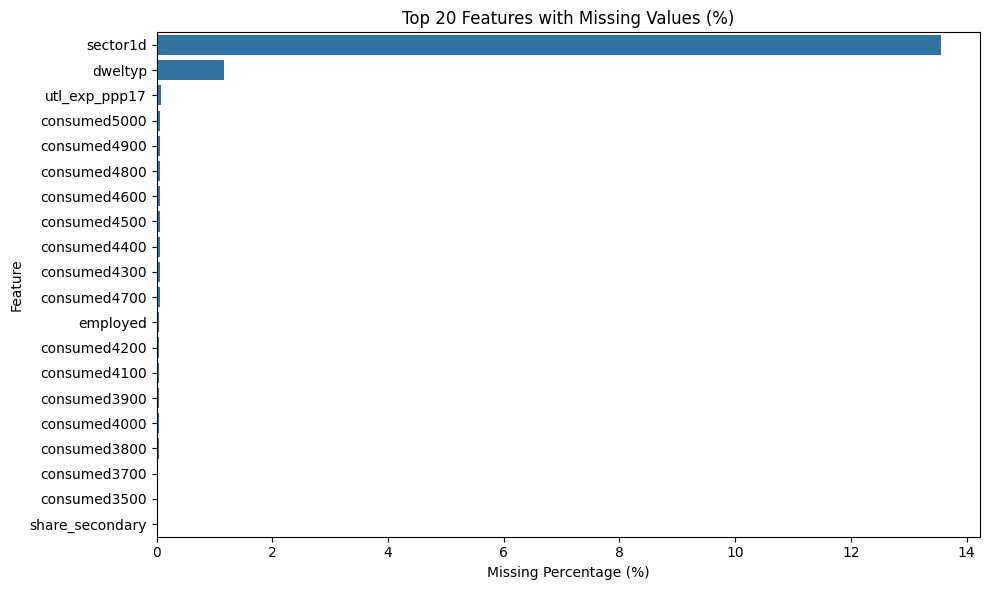

In [24]:
plt.figure(figsize=(10, 6))
top_missing = quality_df.sort_values('missing_pct', ascending=False).head(20)
sns.barplot(x=top_missing['missing_pct'], y=top_missing.index)
plt.title('Top 20 Features with Missing Values (%)')
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Περιγραφική Στατιστική Ανάλυση της Μεταβλητής Στόχου

In [25]:
print("\n--- Consumption Statistics ---")
print(train_df['cons_ppp17'].describe())


--- Consumption Statistics ---
count    104234.000000
mean         11.555229
std          10.034225
min           0.359563
25%           5.439294
50%           8.774002
75%          14.216931
max         236.115680
Name: cons_ppp17, dtype: float64


Οπτική απεικόνιση

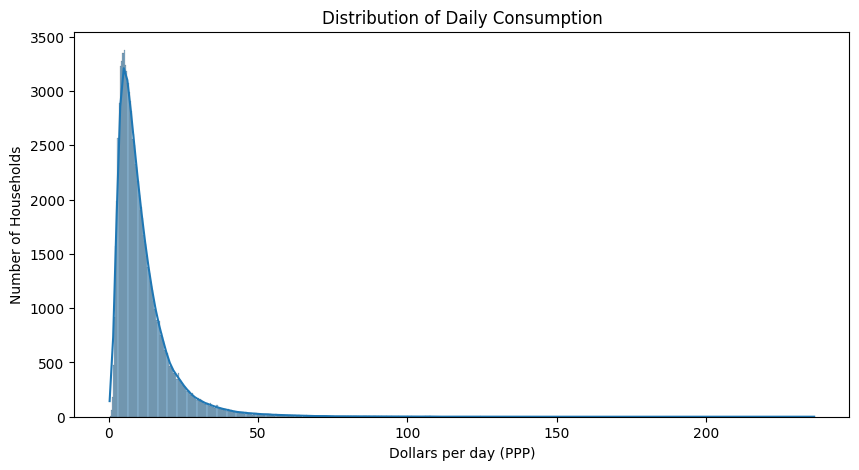

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df['cons_ppp17'], kde=True)
plt.title('Distribution of Daily Consumption')
plt.xlabel('Dollars per day (PPP)')
plt.ylabel('Number of Households')
plt.show()

Ανάλυση Κατηγορικών Μεταβλητών

In [27]:
categorical_cols = train_df.select_dtypes(include='object').columns

print(f"Number of categorical features: {len(categorical_cols)}")

for col in categorical_cols:
    print(f"\nFeature: {col}")
    print(train_df[col].value_counts(normalize=True).head())

Number of categorical features: 64

Feature: male
male
Male      0.725838
Female    0.274162
Name: proportion, dtype: float64

Feature: owner
owner
Owner        0.734309
Not owner    0.265691
Name: proportion, dtype: float64

Feature: water
water
Access       0.818313
No access    0.181687
Name: proportion, dtype: float64

Feature: toilet
toilet
Access       0.702976
No access    0.297024
Name: proportion, dtype: float64

Feature: sewer
sewer
Access       0.598269
No access    0.401731
Name: proportion, dtype: float64

Feature: elect
elect
Access       0.910931
No access    0.089069
Name: proportion, dtype: float64

Feature: water_source
water_source
Piped water into dwelling    0.782029
Surface water                0.073095
Other                        0.040102
Piped water to yard/plot     0.036284
Protected dug well           0.025337
Name: proportion, dtype: float64

Feature: sanitation_source
sanitation_source
A piped sewer system              0.598269
A septic tank                

Συγκριτική Ανάλυση Κατανάλωσης ανά Έρευνα

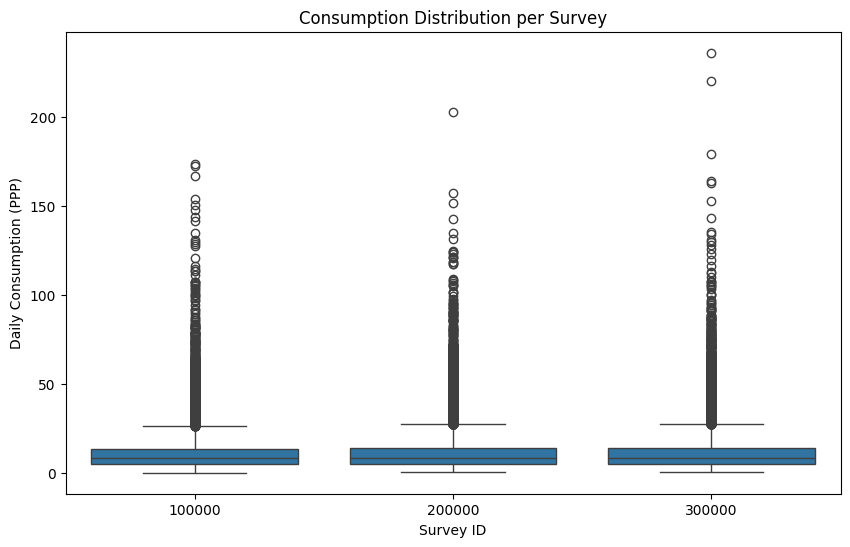

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='survey_id', y='cons_ppp17', data=train_df)
plt.title('Consumption Distribution per Survey')
plt.xlabel('Survey ID')
plt.ylabel('Daily Consumption (PPP)')
plt.show()

Χάρτης Συσχέτισης των Παραγόντων Κατανάλωσης

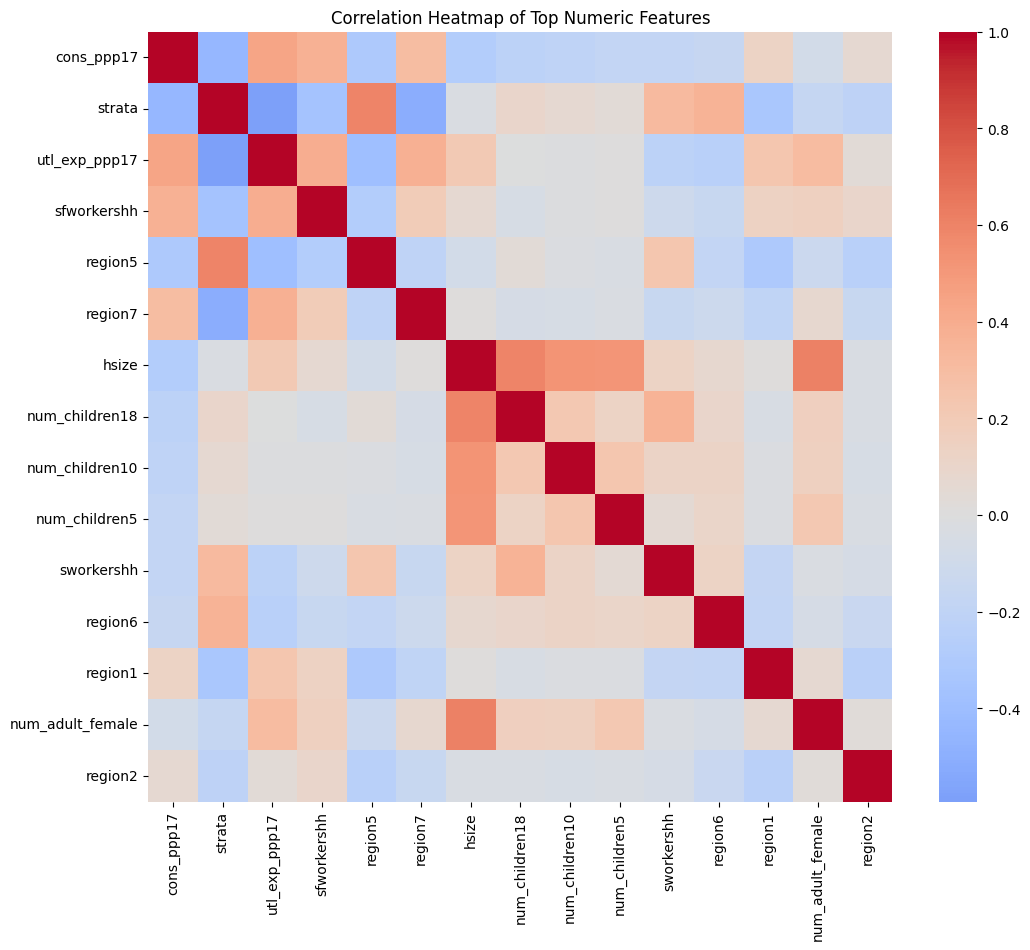

In [29]:
numeric_df = train_df.select_dtypes(include=[np.number])

corr = numeric_df.corr()
top_features = corr['cons_ppp17'].abs().sort_values(ascending=False).head(15).index

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df[top_features].corr(), cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Top Numeric Features')
plt.show()

Ανάλυση Σπουδαιότητας Χαρακτηριστικών μέσω RandomForest

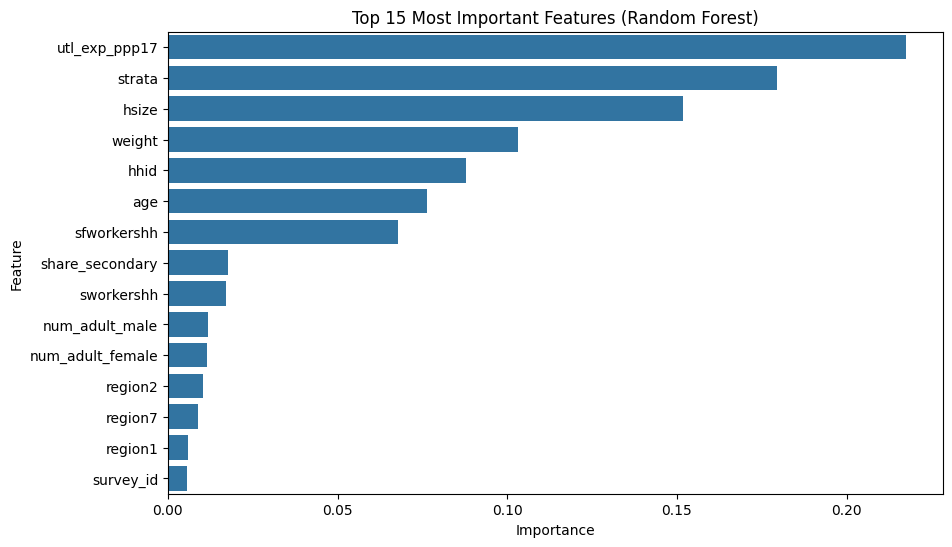

In [30]:
X_tmp = train_df.select_dtypes(include=[np.number]).drop(columns=['cons_ppp17'])
y_tmp = train_df['cons_ppp17']

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_tmp.fillna(X_tmp.median()), y_tmp)

importances = pd.Series(rf.feature_importances_, index=X_tmp.columns)
top_imp = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title('Top 15 Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Διαχωρισμός στηλών σε αριθμητικές και κατηγορικές

In [31]:
numeric_cols = train_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_raw = train_features.select_dtypes(exclude=[np.number]).columns.tolist()

for id_col in ['hhid', 'survey_id']:
    if id_col in numeric_cols:
        numeric_cols.remove(id_col)
    if id_col in categorical_cols_raw:
        categorical_cols_raw.remove(id_col)

Συμπλήρωση Ελλειπουσών Τιμών στο Train Set

In [32]:
for col in numeric_cols:
    if col in train_df.columns:
        med = train_df[col].median()
        train_df[col] = train_df[col].fillna(med)

for col in categorical_cols_raw:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna("Unknown")

Συμπλήρωση Ελλειπουσών Τιμών στο Test Set

In [33]:
for col in numeric_cols:
    if col in test_features.columns:
        med = train_df[col].median() if col in train_df.columns else 0
        test_features[col] = test_features[col].fillna(med)

for col in categorical_cols_raw:
    if col in test_features.columns:
        test_features[col] = test_features[col].fillna("Unknown")

print("The gaps have been successfully filled!")

The gaps have been successfully filled!


Λογαριθμικός Μετασχηματισμός της Μεταβλητής Στόχου

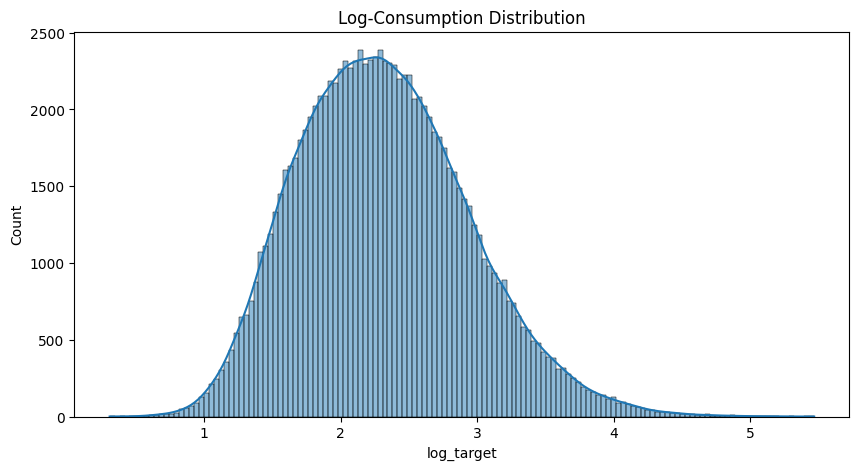

In [34]:
train_df['log_target'] = np.log1p(train_df['cons_ppp17'])

plt.figure(figsize=(10, 5))
sns.histplot(train_df['log_target'], kde=True)
plt.title('Log-Consumption Distribution')
plt.show()

Διαχείριση Κατηγορικών Δεδομένων για LightGBM

In [35]:
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
for id_col in ['hhid', 'survey_id']:
    if id_col in categorical_cols:
        categorical_cols.remove(id_col)

for col in categorical_cols:
    train_df[col] = train_df[col].astype('category')
    test_features[col] = test_features[col].astype('category')

print(f"Category columns as category: {len(categorical_cols)}")

Category columns as category: 64


Feature Engineering - Δημιουργία νέων μεταβλητών που βοηθούν τα μοντέλα να καταλάβουν καλύτερα τα δεδομένα

In [36]:
for df in [train_df, test_features]:

    hsize_safe = df['hsize'].replace(0, np.nan)
    df['dep_ratio'] = (df['num_children18'] + df['num_elderly']) / hsize_safe
    df['dep_ratio'] = df['dep_ratio'].fillna(0)

    food_cols = [c for c in df.columns if 'consumed' in c]
    if len(food_cols) > 0:
        food_tmp = df[food_cols].apply(lambda s: pd.to_numeric(s.astype(str), errors='coerce'))
        df['food_diversity'] = food_tmp.fillna(0).sum(axis=1)
    else:
        df['food_diversity'] = 0

    amen_cols = ['elect', 'water', 'sewer']
    if all(col in df.columns for col in amen_cols):
        def to_flag(series):
            s_num = pd.to_numeric(series.astype(str), errors='coerce')
            if s_num.notna().mean() > 0.8:
                return (s_num.fillna(0) > 0).astype(int)
            else:
                return ((series.astype(str) != "Unknown") & (series.notna())).astype(int)

        df['has_elect'] = to_flag(df['elect'])
        df['has_water'] = to_flag(df['water'])
        df['has_sewer'] = to_flag(df['sewer'])
        df['amenities_score'] = df['has_elect'] + df['has_water'] + df['has_sewer']


Build X/y

In [41]:
categorical_cols = train_df.select_dtypes(
    include=['object', 'category']
).columns.tolist()

for col in ['hhid', 'survey_id', 'cons_ppp17', 'log_target']:
    if col in categorical_cols:
        categorical_cols.remove(col)

for col in categorical_cols:
    train_df[col] = train_df[col].astype('category')
    test_features[col] = test_features[col].astype('category')
y = train_df['log_target']

drop_cols = ['cons_ppp17', 'log_target', 'hhid', 'survey_id']
X = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])

w = train_df['weight'].values if 'weight' in train_df.columns else None
if 'weight' in X.columns:
    X = X.drop(columns=['weight'])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Προετοιμασίας των Πινάκων Εκπαίδευσης

In [45]:
y = train_df['log_target']

id_cols = ['hhid', 'survey_id']
target_cols = ['cons_ppp17', 'log_target']
drop_cols = [c for c in (id_cols + target_cols) if c in train_df.columns]

categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
for c in drop_cols:
    if c in categorical_cols:
        categorical_cols.remove(c)

for col in categorical_cols:
    train_df[col] = train_df[col].astype('category')
    test_features[col] = test_features[col].astype('category')

Δημιουργία Πινάκων για LightGBM

In [46]:
X_lgb = train_df.drop(columns=drop_cols).copy()

w = None
if 'weight' in X_lgb.columns:
    w = X_lgb['weight'].values
    X_lgb = X_lgb.drop(columns=['weight'])

Δημιουργία Πινάκων για ML/DL (One-Hot Encoding)

In [47]:
X_ml = train_df.drop(columns=drop_cols + (['weight'] if 'weight' in train_df.columns else [])).copy()
X_ml = pd.get_dummies(X_ml, columns=categorical_cols, drop_first=False)

Διαχωρισμός σε Σύνολα Εκπαίδευσης και Επαλήθευσης

In [48]:
idx_train, idx_val = train_test_split(train_df.index, test_size=0.2, random_state=42)

X_lgb_train, X_lgb_val = X_lgb.loc[idx_train], X_lgb.loc[idx_val]
X_ml_train,  X_ml_val  = X_ml.loc[idx_train],  X_ml.loc[idx_val]
y_train, y_val = y.loc[idx_train], y.loc[idx_val]

w_train = train_df.loc[idx_train, 'weight'].values if 'weight' in train_df.columns else None
w_val   = train_df.loc[idx_val, 'weight'].values if 'weight' in train_df.columns else None

print("Prepared matrices:")
print("X_lgb_train:", X_lgb_train.shape, "| X_lgb_val:", X_lgb_val.shape)
print("X_ml_train :", X_ml_train.shape,  "| X_ml_val :", X_ml_val.shape)
print("Categorical features (for LGBM):", len(categorical_cols))


Prepared matrices:
X_lgb_train: (83387, 91) | X_lgb_val: (20847, 91)
X_ml_train : (83387, 241) | X_ml_val : (20847, 241)
Categorical features (for LGBM): 64


Εκπαίδευση Μοντέλων

Εκπαίδευση Random Forest

In [50]:
results = []

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_ml_train, y_train)
pred_rf = rf.predict(X_ml_val)
mae_rf = mean_absolute_error(np.expm1(y_val), np.expm1(pred_rf))
results.append(("Random Forest", mae_rf))

Εκπαίδευση XGBoost

In [51]:
xgb_model = xgb.XGBRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_ml_train, y_train, eval_set=[(X_ml_val, y_val)], verbose=False)
pred_xgb = xgb_model.predict(X_ml_val)
mae_xgb = mean_absolute_error(np.expm1(y_val), np.expm1(pred_xgb))
results.append(("XGBoost", mae_xgb))

Εκπαίδευση LightGBM

In [52]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=6000,
    learning_rate=0.02,
    num_leaves=127,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(
    X_lgb_train, y_train,
    sample_weight=w_train,
    eval_set=[(X_lgb_val, y_val)],
    eval_sample_weight=[w_val] if w_val is not None else None,
    callbacks=[lgb.early_stopping(200)],
    categorical_feature=categorical_cols
)
pred_lgb = lgb_model.predict(X_lgb_val)
mae_lgb = mean_absolute_error(np.expm1(y_val), np.expm1(pred_lgb))
results.append(("LightGBM", mae_lgb))

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1126]	valid_0's l2: 0.0831398


Σύγκριση και Ταξινόμιση

In [53]:
results_df = pd.DataFrame(results, columns=["Model", "MAE (USD/day)"]).sort_values("MAE (USD/day)")
print("\nModel comparison (holdout):")
print(results_df)



Model comparison (holdout):
           Model  MAE (USD/day)
1        XGBoost       3.146404
2       LightGBM       3.165798
0  Random Forest       3.402000


Εκπαίδευση Νευρωνικού Δικτύου τύπου Multi-Layer Perceptron

Κανονικοποίηση Δεδομένων

In [56]:
scaler = StandardScaler(with_mean=False)
X_train_s = scaler.fit_transform(X_ml_train)
X_val_s   = scaler.transform(X_ml_val)

Αρχιτεκτονική του Νευρωνικού Δικτύου

In [57]:
dl_model = Sequential([
    Input(shape=(X_train_s.shape[1],)),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.3),
    Dense(128), BatchNormalization(), Activation('relu'), Dropout(0.2),
    Dense(64),  Activation('relu'),
    Dense(1)
])

dl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')

Εκπαίδευση με Early Stopping

In [58]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

dl_model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop],
    verbose=0
)

Τελική Σύγκριση όλων των Μοντέλων

In [59]:
pred_dl = dl_model.predict(X_val_s).flatten()
mae_dl = mean_absolute_error(np.expm1(y_val), np.expm1(pred_dl))

results_df = pd.concat(
    [results_df, pd.DataFrame([["Neural Network (MLP)", mae_dl]], columns=["Model", "MAE (USD/day)"])],
    ignore_index=True
).sort_values("MAE (USD/day)")

print("\nModel comparison (including Deep Learning):")
print(results_df)


652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Model comparison (including Deep Learning):
                  Model  MAE (USD/day)
0               XGBoost       3.146404
1              LightGBM       3.165798
2  Neural Network (MLP)       3.197522
4  Neural Network (MLP)       3.210438
3         Random Forest       3.402000


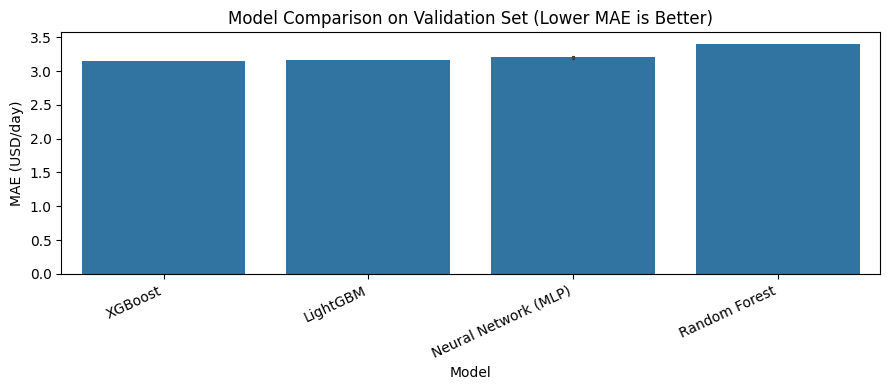

In [61]:
plt.figure(figsize=(9, 4))
sns.barplot(data=results_df, x="Model", y="MAE (USD/day)")
plt.title("Model Comparison on Validation Set (Lower MAE is Better)")
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

Προετοιμασία LOSO (Leave-One-Survey-Out) και Μετρικών Φτώχειας

In [63]:
drop_cols = ['hhid', 'survey_id', 'cons_ppp17', 'log_target', 'weight']
X_all = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns]).copy()
y_all = train_df['log_target'].copy()
w_all = train_df['weight'].values if 'weight' in train_df.columns else None

survey_ids = sorted(train_df['survey_id'].unique())
thresholds = np.array([3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70, 8.40, 9.13,
                       9.87, 10.70, 11.62, 12.69, 14.03, 15.64, 17.76, 20.99, 27.37], dtype=float)

def weighted_poverty_rates(cons, weights, thresholds):
    total_w = weights.sum()
    return np.array([(weights[cons < t].sum() / total_w) for t in thresholds])

Leave-One-Survey-Out (LOSO) Cross-Validation.

In [64]:
cv_maes = []
cv_pov_mapes = []

for val_survey in survey_ids:
    print(f"\nLOSO validation on survey {val_survey}")

    train_mask = (train_df['survey_id'] != val_survey)
    val_mask   = (train_df['survey_id'] == val_survey)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    w_train = train_df.loc[train_mask, 'weight'].values if 'weight' in train_df.columns else None

    X_val = X_all.loc[val_mask]
    y_val = y_all.loc[val_mask]
    w_val = train_df.loc[val_mask, 'weight'].values if 'weight' in train_df.columns else None

    model = lgb.LGBMRegressor(
        n_estimators=6000,
        learning_rate=0.02,
        num_leaves=127,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    model.fit(
        X_train, y_train,
        sample_weight=w_train,
        eval_set=[(X_val, y_val)],
        eval_sample_weight=[w_val] if w_val is not None else None,
        callbacks=[lgb.early_stopping(200)],
        categorical_feature=categorical_cols
    )

    pred_val = np.clip(np.expm1(model.predict(X_val)), 0, None)
    actual_val = np.expm1(y_val)
    mae = mean_absolute_error(actual_val, pred_val)
    cv_maes.append(mae)

    val_weights = train_df.loc[val_mask, 'weight'].values
    pred_rates = weighted_poverty_rates(pred_val, val_weights, thresholds)
    true_rates = weighted_poverty_rates(actual_val.values, val_weights, thresholds)

    eps = 1e-9
    mape = np.mean(np.abs((pred_rates - true_rates) / (true_rates + eps)))
    cv_pov_mapes.append(mape)

    print(f"   MAE: {mae:.3f} | Poverty MAPE (proxy): {mape:.4f}")

avg_mae_loso = float(np.mean(cv_maes))
avg_pov_mape_loso = float(np.mean(cv_pov_mapes))

print("\nLOSO CV summary (LightGBM)")
print(f"Average MAE: {avg_mae_loso:.3f}")
print(f"Average Poverty MAPE (proxy): {avg_pov_mape_loso:.4f}")


LOSO validation on survey 100000
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1127]	valid_0's l2: 0.0858185
   MAE: 3.133 | Poverty MAPE (proxy): 0.0953

LOSO validation on survey 200000
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1082]	valid_0's l2: 0.084043
   MAE: 3.186 | Poverty MAPE (proxy): 0.0797

LOSO validation on survey 300000
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1360]	valid_0's l2: 0.0852903
   MAE: 3.227 | Poverty MAPE (proxy): 0.0859

LOSO CV summary (LightGBM)
Average MAE: 3.182
Average Poverty MAPE (proxy): 0.0870


Τελική εκπαίδευση αφού επιβεβαιώσουμε από το LOSO ότι το μοντέλο αποδίδει σταθερά

In [65]:
final_model = lgb.LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.02,
    num_leaves=127,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

final_model.fit(
    X_all, y_all,
    sample_weight=w_all,
    categorical_feature=categorical_cols
)

print("\nFinal model trained on all data (LightGBM).")


Final model trained on all data (LightGBM).


Παραγωγή των τελικών αρχείων υποβολής

In [66]:
X_test = test_features[X_all.columns].copy()

test_preds_log = final_model.predict(X_test)
test_preds_cons = np.expm1(test_preds_log)
test_preds_cons = np.clip(test_preds_cons, 0, None)

submission_cons = pd.DataFrame({
    'survey_id': test_features['survey_id'].values,
    'hhid': test_features['hhid'].values,
    'cons_ppp17': test_preds_cons
})

threshold_labels = [
    "3.17", "3.94", "4.60", "5.26", "5.88", "6.47", "7.06", "7.70", "8.40", "9.13",
    "9.87", "10.70", "11.62", "12.69", "14.03", "15.64", "17.76", "20.99", "27.37"
]
threshold_vals = np.array([float(x) for x in threshold_labels], dtype=float)

poverty_rows = []

preds_series = pd.Series(test_preds_cons, index=test_features.index)

for s_id in sorted(test_features['survey_id'].unique()):
    row = {'survey_id': int(s_id)}

    mask = (test_features['survey_id'] == s_id)
    s_preds = preds_series.loc[mask].values
    s_weights = test_features.loc[mask, 'weight'].values

    total_weight = s_weights.sum()

    for lab, t in zip(threshold_labels, threshold_vals):
        below_w = s_weights[s_preds < t].sum()
        row[f'pct_hh_below_{lab}'] = below_w / total_weight

    poverty_rows.append(row)

submission_rates = pd.DataFrame(poverty_rows)

poverty_cols = [c for c in submission_rates.columns if c.startswith('pct_hh_below_')]
submission_rates[poverty_cols] = submission_rates[poverty_cols].clip(0, 1)
submission_rates[poverty_cols] = submission_rates[poverty_cols].cummax(axis=1)

submission_cons.to_csv('predicted_household_consumption.csv', index=False)
submission_rates.to_csv('predicted_poverty_distribution.csv', index=False)
